Uwaga dydaktyczna: Celem laboratorium nie jest napisanie „szybkiego” solwera LP, lecz zrozumienie geometrii i mechaniki algorytmu simpleks poprzez implementację wersji edukacyjnej.

Do rozwiązywania równania $Ax = b$ będziemy wywoływać `x = np.linalg.solve(A, b)`, co w używanych w praktyce solverach jest sprytnie pomijane.

UWAGA: W tym pliku indeksujemy od 0.

In [25]:
import itertools
import numpy as np

tol = 1e-12

# Zadanie programowania liniowego

Rozważamy zadanie:
$\min_{x\in\mathbb{R}^m}\ b^T x$
przy ograniczeniach
$Cx - d = 0,$
$x \ge 0,$

gdzie:
- $b \in \mathbb{R}^m$,
- $d \in \mathbb{R}^p$,
- $C : \mathbb{R}^{p\times m}$,
- $\operatorname{rank} C = p$, $1 \le p < m$.

UWAGA: Zadanie to jest wypukłe, a więc każde rozwiązanie lokalne jest globalne.

### Przykłady zastosowań zadania programowania liniowego

* problemy transportowe i logistyczne (minimalizacja kosztów przy zadanych bilansach podaży i popytu),
* replikacja portfela finansowego i dopasowanie przepływów pieniężnych,
* analiza strumieni metabolicznych w biologii systemowej (Flux Balance Analysis).

### Twierdzenie

Jeśli rozwiązanie istnieje, to istnieje rozwiązanie, które ma co najmniej $m-p$ zer.

## Brute Force Simplex

Gdy mamy bazę $\mathcal{B}\subset \{0,1,2,\ldots,m-1\}$, $|\mathcal{B}| = p$, to mamy jej dopełnienie $\mathcal{N} = \{0,1,2,\ldots,m-1\}\setminus \mathcal{B}$, $|\mathcal{N}| = n-p$ na której $x_{\mathcal{N}} = 0$ i potem $x_{\mathcal{B}}$ jest wyznaczona jednoznacznie z równania $Cx = d$.

Idea: Przejrzyj wszystkie Bazy. Jest ich ${m\choose p} \approx \frac{m^p}{p!}$. Dla każdej możliwej bazy policz $x$. Znajdź $x \ge 0$ z najmniejszą wartością funkcji celu.

UWAGA: Jest to algorytm, który bardzo słabo się skaluje. Będzie się dało go wykonać tylko dla małych $m$.

In [26]:
def eval_basis(C, d, b, B):
    """
    Dla danej bazy B oblicza punkt bazowy.

    Zwraca slownik:
      x_B      - wektor zmiennych bazowych (w kolejnosci B)
      feasible - czy punkt jest dopuszczalny
    """
    p, m = C.shape

    C_B = C[:, B]
    if (np.linalg.matrix_rank(C_B) < p):
        return {
            "x_B": None,
            "feasible": False
        }
    
    x_B = np.linalg.solve(C_B, d)

    return {
        "x_B": x_B,
        "feasible": bool(np.all(x_B >= -tol))
    } 

In [27]:
def brute_force_simplex(C, d, b):
    """
    Przeglada wszystkie mozliwe bazy i wybiera najlepsze rozwiazanie dopuszczalne.

    Zwraca slownik:
      best_x   - najlepszy znaleziony punkt
      best_obj - wartosc funkcji celu
      best_B   - baza odpowiadajaca best_x
    """
    p, m = C.shape
    
    best_x = None
    best_B = None
    best_obj = np.inf
    
    for B in itertools.combinations(range(m), p):
        B = list(B)
        
        # 1. Obliczamy punkt dla danej bazy (używając Twojej funkcji)
        result = eval_basis(C, d, b, B)
        
        # 2. Jeśli punkt jest "legalny" (dopuszczalny, czyli x >= 0)
        if result["feasible"]: 
            x_B = result["x_B"]
            
            # 3. Obliczamy wartość funkcji celu (koszt)
            # Mnożymy ceny (b) tylko dla zmiennych bazowych, bo reszta to zera.
            current_obj = np.dot(b[B], x_B)
            
            # 4. Jeśli znaleźliśmy lepszy (mniejszy) koszt, aktualizujemy rekord
            if current_obj < best_obj:
                best_obj = current_obj
                best_B = B
                
                # 5. Tworzymy pełny wektor x (rozmiaru m), żeby go zwrócić
                # Domyślnie same zera, a w miejsca z Bazy wstawiamy wyliczone wartości
                best_x = np.zeros(m)
                best_x[B] = x_B

    return {
        "best_x": best_x,
        "best_obj": best_obj,
        "best_B": best_B
    }

In [28]:
C = np.array([
    [1, 1, 1, 0],
    [4, 1, 0, 1],
])

d = np.array([5, 16])
b = np.array([-5, -1, 0, 0])

In [29]:
brute_force_simplex(C, d, b)
# {'best_x': array([4., 0., 1., 0.]), 'best_obj': -20.0, 'best_B': [0, 2]}

{'best_x': array([4., 0., 1., 0.]), 'best_obj': -20.0, 'best_B': [0, 2]}

# Revised simplex

IDEA: Zmieńmy $\mathcal{B}$ o jedną zmienną tak, aby wciąż $x \ge 0$ oraz żeby funkcja celu się zmniejszyła. Dzięki temu przejrzymy dużo mniej baz niż *Brute Force Simplex*.

UWAGA: Działa tylko, jeśli znamy *jakiś* zbiór $\mathcal{B}$ dający $x_{\mathcal{B}} \ge 0$. Jeśli takiego nie znamy, to musimy go jakoś znaleźć, i do tego służy sztuczka (algorytm), który jest do zaimplementowania w części domowej.

### Podział zmiennych
Zbiór indeksów zmiennych dzielimy na:
- $\mathcal{B}$ — zbiór zmiennych bazowych,
- $\mathcal{N}$ — zbiór zmiennych niebazowych.

Niech $C_{\mathcal{B}} = [\, C_i \,]_{i \in \mathcal{B}}$, $C_{\mathcal{N}} = [\, C_i \,]_{i \in \mathcal{N}}$.

Punkt bazowy $x_{\mathcal{N}} = 0$, $x_{\mathcal{B}} = C_{\mathcal{B}}^{-1} d$.

Zakładamy $x_{\mathcal{B}} \ge 0$.

---

### Krok 1 (mnożniki dualne)
Wyznacz $\lambda \in \mathbb{R}^p$ z równania $C_{\mathcal{B}}^T \lambda = b_{\mathcal{B}}$.

UWAGA: $\lambda$ to mnożniki Lagrange’a z warunków KKT dla ograniczeń równościowych $Cx=d$.

---

### Krok 2 (koszty zredukowane)
Dla zmiennych niebazowych oblicz:
$s_{\mathcal{N}} = b_{\mathcal{N}} - C_{\mathcal{N}}^T \lambda.$

Jeżeli $s_{\mathcal{N}} \ge 0$ na każdej współrzędnej, to punkt $x$ jest rozwiązaniem optymalnym. Nie da się poprawić. Koniec algorytmu.

UWAGA: Koszty zredukowane $s$ to mnożniki KKT dla ograniczeń nieujemności $x_i\ge0$. Dlatego gdy są one $s\ge 0$, to mamy spełnione KKT, a więc mamy optimum (bo problem jest wypukły).

---

### Krok 3 (wybór zmiennej wchodzącej do $\mathcal{B}$)
Wybierz indeks $j \in \mathcal{N}$ taki, że: $s_j < 0.$

UWAGA: Teoretycznie można wybrać dowolny. My wybierzmy najmniejsze $j = \arg\min_{i \in \mathcal{N}}\{s_i\}$.

---

### Krok 4 (kierunek)
Wyznacz wektor $z \in \mathbb{R}^p$ z równania $C_{\mathcal{B}} z = C_j$.

UWAGA: Wektor $z$ indeksujemy zmiennymi bazowymi (patrz przykład).

UWAGA: $z\in\mathbb{R}^p$. Rozszerzmy go do $z'\in\mathbb{R}^m$ poprzez wstawienie zer, czyli: $z'_{\mathcal{B}} = z$, $z'_{\mathcal{N}} = 0$. Zauważ, że dla wszystkich $t\in\mathbb{R}$ wektor $x - t\cdot z' + t\cdot e_j$ spełnia ograniczenia równościowe: $C(x - t\cdot z' + t\cdot e_j) = d$.

Jeżeli $z \le 0$ na każdej współrzędnej, to zadanie jest nieograniczone.

---

### Krok 5 (test ilorazowy)
Znajdźmy największe $t\in [0,\infty)$ takie, że wektor $x - t\cdot z' + t\cdot e_j \ge 0$. Czyli: $\alpha = \arg\max_{x - t\cdot z' + t\cdot e_j \ge 0} \{t\}$. Można to zrobić tak:

$$
\alpha = \min_{i \in \mathcal{B},\ z_i > 0}
\frac{(x_{\mathcal{B}})_i}{z_i}.
$$

Niech $k$ będzie indeksem, który się wtedy zeruje:
$$
k = \arg\min_{i \in \mathcal{B},\ z_i > 0}
\frac{(x_{\mathcal{B}})_i}{z_i}.
$$

UWAGA: Mamy $(x - \alpha\cdot z' + \alpha\cdot e_j)_{k} = 0$.

UWAGA: $k$ może być niejednoznaczne! Wtedy wybierz dowolny.

---

### Krok 6 (aktualizacja)
Aktualizacja punktu:
$$
x_{\mathcal{B}} \leftarrow x_{\mathcal{B}} - \alpha z,
\qquad
x_j \leftarrow \alpha.
$$

Aktualizacja bazy:
$$
\mathcal{B} \leftarrow (\mathcal{B} \setminus \{k\}) \cup \{j\},
\qquad
\mathcal{N} \leftarrow (\mathcal{N} \setminus \{j\}) \cup \{k\}.
$$

Następnie wróć do Kroku 1.


---
---

## Przykład

Dane:
$$
C =
\begin{pmatrix}
1 & 1 & 1 & 0\\
4 & 1 & 0 & 1
\end{pmatrix},\quad
d =
\begin{pmatrix}
5\\16
\end{pmatrix},\quad
b =
\begin{pmatrix}
-5\\-1\\0\\0
\end{pmatrix}.
$$
Indeksować będziemy od 0: $x = (x_0,x_1,x_2,x_3)^T$.

Weźmy bazę startową $\mathcal{B}_0 = [2,3]$, więc $\mathcal{N}_0=[0,1]$.
Mamy
$$
C_{\mathcal{B}_0} = [C_2, C_3] =
\begin{pmatrix}
1 & 0\\
0 & 1
\end{pmatrix}.
$$

### Iteracja 0

**Punkt bazowy.** Ponieważ $x_{\mathcal{N}}=0$, to
$$
x_{\mathcal{B}_0} = C_{\mathcal{B}_0}^{-1} d = d =
\begin{pmatrix}
5\\16
\end{pmatrix},
$$
czyli $x_2=5$, $x_3=16$, $x_0=x_1=0$. Punkt jest dopuszczalny (wszystkie wyszły $\ge 0$).

Zaczynamy więc z punktu $\bf{x = (0,0,5,16)^T}$.

**Krok 1 (mnożniki dualne).**  
Rozwiązujemy $C_{\mathcal{B}_0}^T \lambda = b_{\mathcal{B}_0}$.
Tu $b_{\mathcal{B}_0}=(b_2,b_3)=(0,0)$ oraz $C_{\mathcal{B}_0}^T=I$, więc
$$
\lambda = (0,0).
$$

**Krok 2 (koszty zredukowane).**  
Dla $\mathcal{N}_0=[0,1]$:
$$
s_{\mathcal{N}_0} = b_{\mathcal{N}_0} - C_{\mathcal{N}_0}^T \lambda
= b_{\mathcal{N}_0} = (b_0,b_1)=(-5,-1).
$$
Nie jest optimum, bo są ujemne koszty zredukowane.

**Krok 3 (zmienna wchodząca).**  
Wybieramy najbardziej ujemny koszt: $j=0$ (bo $s_0=-5$).

**Krok 4 (kierunek).**  
Rozwiązujemy $C_{\mathcal{B}_0} z = C_j = C_0 = (1,4)^T$.
Ponieważ $C_{\mathcal{B}_0}=I$, mamy
$$
z = (z_2, z_3)^T = (1,4)^T.
$$

**Krok 5 (test ilorazowy).**
$$
\alpha = \min_{i\in\mathcal{B}_0,\ z_i>0}
\frac{(x_{\mathcal{B}_0})_i}{z_i}
= \min\left\{\frac{5}{1},\frac{16}{4}\right\}
= \min\{5,4\} = 4.
$$
Minimum osiąga druga współrzędna, więc z bazy wychodzi $k=3$.

**Krok 6 (aktualizacja).**  
Aktualizujemy:
$$
x_{\mathcal{B}_0} \leftarrow x_{\mathcal{B}_0}-\alpha z =
\begin{pmatrix}5\\16\end{pmatrix}
- 4\begin{pmatrix}1\\4\end{pmatrix}
=
\begin{pmatrix}1\\0\end{pmatrix},
\qquad
x_0 \leftarrow \alpha = 4.
$$
Nowa baza:
$$
\mathcal{B}_1 = [2,0],\quad \mathcal{N}_1=[1,3].
$$

**Nowy punkt**
$\bf{x = (4,0,1,0)^T}$

### Iteracja 1

**Punkt bazowy.**
$$
C_{\mathcal{B}_1} = [C_2,C_0] =
\begin{pmatrix}
1 & 1\\
0 & 4
\end{pmatrix}.
$$
Rozwiązujemy $C_{\mathcal{B}_1} x_{\mathcal{B}_1}=d$:
z drugiego równania $4x_0=16 \Rightarrow x_0=4$,
z pierwszego $x_2+x_0=5 \Rightarrow x_2=1$.
Zatem $x=(4,0,1,0)^T$ (zgadza się).

**Krok 1 (mnożniki dualne).**  
Rozwiązujemy $C_{\mathcal{B}_1}^T \lambda=b_{\mathcal{B}_1}$.
Tu $b_{\mathcal{B}_1}=(b_2,b_0)=(0,-5)$ oraz
$$
C_{\mathcal{B}_1}^T =
\begin{pmatrix}
1 & 0\\
1 & 4
\end{pmatrix}.
$$
Dostajemy:
$$
\lambda_1=0,\quad \lambda_1+4\lambda_2=-5
\Rightarrow \lambda_2=-\frac{5}{4}=-1.25,
$$
czyli $\lambda=(0,-1.25)$.

**Krok 2 (koszty zredukowane).**  
Dla $\mathcal{N}_1=[1,3]$:
- $C_1=(1,1)^T$, więc $C_1^T\lambda = -1.25$,
  $$
  s_1 = b_1 - C_1^T\lambda = -1 - (-1.25) = 0.25 \ge 0.
  $$
- $C_3=(0,1)^T$, więc $C_3^T\lambda = -1.25$,
  $$
  s_3 = b_3 - C_3^T\lambda = 0 - (-1.25) = 1.25 \ge 0.
  $$

Ponieważ $s_{\mathcal{N}_1}\ge 0$, punkt $x=(4,0,1,0)^T$ jest optymalny i algorytm kończy działanie.
Wartość funkcji celu:
$$
b^T x = -5\cdot 4 -1\cdot 0 = -20.
$$


In [30]:
def basis_complement(B, m):
    """
    Zwraca zbior indeksow zmiennych niebazowych
    """
    inB = set(B)
    return [i for i in range(m) if i not in inB]

In [31]:
def eval_basis_rs(C, d, b, B):
    """
    Ocena bazy dla algorytmu revised simplex.

    Oblicza:
      - punkt bazowy
      - zbior zmiennych niebazowych
      - mnozniki dualne lambda
      - koszty zredukowane
      - warunek optymalnosci
    """
    p, m = C.shape

    base = eval_basis(C, d, b, B)
    x_B = base["x_B"]
    feasible = base["feasible"]
    
    if (not feasible):
        return {
            "x_B": x_B,
            "feasible": False,
            "N": None,
            "lam": None,
            "s_N": None,
            "optimal": None
        }

    N = basis_complement(B, m)

    C_B = C[:, B]
    b_B = b[B]
    
    # Step 1: C_B^T lam = b_B
    lam = np.linalg.solve(C_B.T, b_B)

    # Step 2: reduced costs on N
    C_N = C[:, N]
    b_N = b[N]
    s_N = b_N - C_N.T @ lam

    return {
        "x_B": x_B,
        "feasible": True,
        "N": N,
        "lam": lam,
        "s_N": s_N,
        "optimal": bool(np.all(s_N >= -tol))
    }

In [32]:
def pivot_step(C, d, b, B):
    """
    Wykonuje jeden krok algorytmu revised simplex.

    Zwraca:
      - nowa baze
      - slownik diagnostyczny ze statusem:
        "optimal", "unbounded" albo "continue"
    """
    p, m = C.shape
    info = eval_basis_rs(C, d, b, B)

    if not info["feasible"]:
        raise RuntimeError("Baza daje niedopuszczalnego x.")

    if info["optimal"]:
        return B, {"status": "optimal"}

    N = info["N"]
    s_N = info["s_N"]

    #pass # TODO(Zaimplementuj kroki 3, 4, 5, 6)
    # W odpowiednim miejscu zwróć "status": "optimal", oraz w innym "status": "unbounded".
    j = N[np.argmin(s_N)]
    z = np.linalg.solve(C[:, B], C[:, j])
    if np.all(z <= 0):
        return B, {
            "status": "unbounded"
        }
    
    alpha = np.infty
    k = None
    for i in range(p):
        if z[i] <= 0:
            continue
        alpha_temp = info["x_B"][i] / z[i]
        if alpha_temp < alpha:
            alpha = alpha_temp
            k = B[i]
    
    B_new = B.copy()
    B_new.remove(k)
    B_new = B_new + [j]
    return B_new, {
        "status": "continue",
        "entering": j,
        "leaving": k,
        "alpha": alpha
    }

In [33]:
# def revised_simplex(C, d, b, B0 = None, max_iter=10000, verbose=False):
#     """
#     Glowna petla algorytmu revised simplex.
#     """
#     if B0 is None:
#         raise Exception("Nalezy podac poczatkowa baze B0!")
#     p, m = C.shape
#     B = B0

#     for it in range(max_iter):
#         B_new, diagnostics = pivot_step(C, d, b, B)
        
#         if diagnostics["status"] == "optimal":
#             info = eval_basis(C, d, b, B)
#             x = np.zeros(m)
#             x[B] = info["x_B"]
#             obj = b.T @ x
#             return {
#                 "status": "optimal",
#                 "x": x,
#                 "obj": obj,
#                 "B": B,
#                 "iterations": it
#             }

#         if diagnostics["status"] == "unbounded":
#             return {
#                 "status": "unbounded",
#                 "x": None,
#                 "obj": None,
#                 "B": B,
#                 "iterations": it
#             }

#         # nie "optimal", nie "unbounded", więc w poprzedniej iteracji byla zmiana; kontynuuj algorytm:
#         if verbose:
#             print("enter j=%d, leave k=%d, alpha=%.6g" % (diagnostics["entering"], diagnostics["leaving"], diagnostics["alpha"]))
#         B = B_new

#     return {
#         "status": "iteration_limit",
#         "x": None,
#         "obj": None,
#         "B": B,
#         "iterations": max_iter
#     }

In [34]:
# revised_simplex(C, d, b, list([2,3]))
# # {'status': 'optimal',
# #  'x': array([4., 0., 1., 0.]),
# #  'obj': -20.0,
# #  'B': [2, 0],
# #  'iterations': 1}

# Praca Domowa

---

## Zadanie 1. Punkt początkowy (Phase I); 2 pkt

W laboratorium algorytm revised simplex zakłada, że znamy bazę startową `B0`, dla której punkt bazowy jest dopuszczalny, tzn. po rozwiązaniu układu `C_B x_B = d` otrzymujemy `x_B >= 0`.

Twoje zadanie: opisz i zaimplementuj sposób znalezienia punktu początkowego metodą *Phase I*.

### Jak to zrobić (opis metody Phase I)

Chcemy rozwiązać problem:
$$
\min_{x \in \mathbb{R}^m} b^\top x
$$
przy ograniczeniach:
$$
Cx = d; x \ge 0
$$

1. Najpierw doprowadź prawą stronę do postaci `d >= 0`:
   - dla każdego wiersza i, jeśli `d[i] < 0`, to pomnóż cały i-ty warunek przez `-1`. Taka zmiana nie zmienia warunku.

2. Rozważ nowe zadanie:
$$
\min_{x \in \mathbb{R}^m, a \in \mathbb{R}^p} \mathbb{1}^\top a
$$
przy ograniczeniach:
$$
Cx + Ia = d; x \ge 0, a \ge 0
$$

3. Rozwiąż nowe zadanie algorytmem simpleks biorąc bazę początkową złożoną tylko ze zmiennych odpowiadających zmiennym $a$.

4. Jeśli algorytm zwrócił wynik mówiący, że wartość funkcji celu jest dodatnia, to znaczy, że nasz oryginalny problem nie ma żadnego punktu dopuszczalnego.

5. Jeśli algorytm zwrócił wynik zerujący funkcję celu, to znaczy, że znalazł bazę złożoną wyłącznie ze zmiennych odpowiadających $x$. Ta sama baza jest też dobrą bazą dla naszego oryginalnego problemu.

### Zadanie
Zaimplementuj to rozwiązanie jako domyślne zachowanie algorytmu `revised_simplex()` jeśli funkcja ta zostanie zawołana z wartością `B0 = None`.


In [35]:
def revised_simplex(C, d, b, B0 = None, max_iter=10000, verbose=False):
    """
    Glowna petla algorytmu revised simplex.
    """
    p, m = C.shape
    
    # === IMPLMENTACJA PHASE I (Zadanie 1) ===
    if B0 is None:
        # 1. Doprowadzenie do d >= 0
        C_phase1 = C.copy()
        d_phase1 = d.copy()
        
        # p = liczba ograniczeń, m = liczba zmiennych oryginalnych
        for i in range(p):
            if d_phase1[i] < 0:
                d_phase1[i] *= -1
                C_phase1[i, :] *= -1
        
        # 2. Konstrukcja zadania pomocniczego
        # Macierz [C | I] -> wymiar p x (m + p)
        I_matrix = np.eye(p)
        C_aux = np.hstack((C_phase1, I_matrix))
        
        # Wektor kosztów b_aux: 0 dla zmiennych x, 1 dla zmiennych sztucznych a
        # Wymiar (m + p)
        b_aux = np.concatenate((np.zeros(m), np.ones(p)))
        
        # Baza startowa: same zmienne sztuczne.
        # Ich indeksy to m, m+1, ..., m+p-1
        B_aux_start = list(range(m, m + p))
        
        # 3. Rozwiązanie zadania pomocniczego 
        phase1_result = revised_simplex(C_aux, d_phase1, b_aux, B0=B_aux_start, max_iter=max_iter, verbose=False)
        
        # 4. Sprawdzenie wyniku Fazy 1
        if phase1_result["status"] != "optimal":
             return {
                "status": "infeasible",
                "x": None,
                "obj": None,
                "message": "Faza 1 nie znalazła rozwiązania (status nie-optimal)."
            }
        
        # Sprawdzamy, czy funkcja celu (suma zmiennych sztucznych) zeszła do zera
        # Używamy małej tolerancji 1e-9 na błędy numeryczne
        if phase1_result["obj"] > 1e-9:
            return {
                "status": "infeasible",
                "x": None,
                "obj": None,
                "message": "Problem sprzeczny - nie udało się wyzerować zmiennych sztucznych."
            }
            
        # 5. Bierzemy znalezioną bazę do Fazy 2
        B = phase1_result["B"]
        
    else:
        # Jeśli użytkownik podał bazę, używamy jej
        B = B0
    # === KONIEC PHASE I ===
    

    for it in range(max_iter):
        B_new, diagnostics = pivot_step(C, d, b, B)
        
        if diagnostics["status"] == "optimal":
            info = eval_basis(C, d, b, B)
            x = np.zeros(m)
            x[B] = info["x_B"]
            obj = b.T @ x
            return {
                "status": "optimal",
                "x": x,
                "obj": obj,
                "B": B,
                "iterations": it
            }

        if diagnostics["status"] == "unbounded":
            return {
                "status": "unbounded",
                "x": None,
                "obj": None,
                "B": B,
                "iterations": it
            }

        # nie "optimal", nie "unbounded", więc w poprzedniej iteracji byla zmiana; kontynuuj algorytm:
        if verbose:
            print("enter j=%d, leave k=%d, alpha=%.6g" % (diagnostics["entering"], diagnostics["leaving"], diagnostics["alpha"]))
        B = B_new

    return {
        "status": "iteration_limit",
        "x": None,
        "obj": None,
        "B": B,
        "iterations": max_iter
    }

In [36]:
revised_simplex(C, d, b)
# {'status': 'optimal',
#  'x': array([4., 0., 1., 0.]),
#  'obj': -20.0,
#  'B': [2, 0],
#  'iterations': 1}

{'status': 'optimal',
 'x': array([4., 0., 1., 0.]),
 'obj': -20.0,
 'B': [0, 2],
 'iterations': 0}

## Zadanie 2. Jak przejść z nierówności do równości; 1 pkt

Rozważ problem w postaci:
$$
\min_{x \in \mathbb{R}^m} b^\top x
$$
przy ograniczeniach:
$$
Cx \le d; x \ge 0
$$

Aby użyć algorytmu simplex z laboratorium, do każdej nierówności dodajemy zmienną luzu `s >= 0`.

### Zadanie
Użyj algorytmu z zajęć do rozwiązania poniższego problemu:

$$
\min_{x \in \mathbb{R}^7} b^\top x
$$
przy ograniczeniach:
$$
C_{\text{ineq}}x \le d_{\text{ineq}}; C_{\text{eq}}x = d_{\text{eq}}; x \ge 0
$$

In [37]:
C_ineq = np.array([
    [ 1,  2,  0,  1,  0,  0,  0],
    [ 0,  1,  1,  0,  1,  0,  0],
    [ 2,  0,  1,  0,  0,  1,  0],
    [ 0,  0,  1,  1,  0,  0,  1],
])

d_ineq = np.array([8, 6, 7, 5])

C_eq = np.array([[1, 0, 0, 1, 0, 0, 0]])
d_eq = np.array([3])

b = np.array([1, 2, 1, 0, 0, 0, 0])

In [38]:
# Pobieramy wymiary
m_ineq, n = C_ineq.shape  # 4 nierówności, 7 zmiennych
m_eq = C_eq.shape[0]      # 1 równość

# 1. Konstrukcja macierzy C
# Dla nierówności dodajemy macierz jednostkową (zmienne luzu)
I_slack = np.eye(m_ineq)
# Dla równości dodajemy zera (brak zmiennych luzu)
Zeros_eq = np.zeros((m_eq, m_ineq))

# Łączenie bloków:
# Góra: [ C_ineq | I ]
Top = np.hstack((C_ineq, I_slack))
# Dół:  [ C_eq   | 0 ]
Bottom = np.hstack((C_eq, Zeros_eq))

# Cała macierz C
C_full = np.vstack((Top, Bottom))

# 2. Konstrukcja wektora d (prawa strona)
d_full = np.concatenate((d_ineq, d_eq))

# 3. Konstrukcja wektora b (funkcja celu)
# Oryginalne koszty + zera dla zmiennych luzu
b_full = np.concatenate((b, np.zeros(m_ineq)))

# 4. Rozwiązanie problemu
# Używamy B0=None, aby Faza 1 znalazła start
result = revised_simplex(C_full, d_full, b_full, B0=None)

print("Status:", result["status"])
print("Wartość funkcji celu:", result["obj"])
# Interesują nas tylko oryginalne zmienne (pierwsze n=7), reszta to luz
print("Rozwiązanie x:", result["x"][:n])

Status: optimal
Wartość funkcji celu: 0.0
Rozwiązanie x: [0. 0. 0. 3. 6. 7. 2.]


## Zadanie 3. Problem transportu węgla (dane w Python); 3 pkt

W tym zadaniu rozważamy 5 kopalni (K1–K5) i 6 elektrowni (E1–E6). Chcemy zaprojektować przesył węgla z kopalni do elektrowni zapewniając dla każdej elektrowni jej zapotrzebowanie, oraz minimalizując koszty przesyłu.

### Zadanie:
1. Zapisz problem jako LP (funkcja celu + ograniczenia), gdzie część ograniczeń jest równościowych, a część nierównościowych.
2. Przepisz go do postaci pasującej do algorytmu simplex z laboratorium (równości, wszystkie zmienne >= 0).
3. Rozwiąż problem i wypisz wysyłki oraz całkowity koszt.
4. Ile baz przejrzała Twoja implementacja algorytmu simplex? Ile przejrzałaby wersja brute force? Wylosuj 2000 baz i sprawdź ile czasu potrzebował algorytm brute force na przejrzenie ich -- na tej podstawie oszacuj ile zajęłoby mu przejrzenie wszystkich baz.

In [39]:
# koszt[i,j] = koszt przesłania 1 tony z kopalni i do elektrowni j
koszt = np.array([
    [12, 18, 10, 22, 15, 19],
    [14, 16, 12, 20, 17, 21],
    [11, 19, 13, 18, 14, 16],
    [15, 17, 11, 19, 16, 14],
    [13, 15, 14, 21, 12, 18],
])

# popyt[j] = zapotrzebowanie elektrowni j (w tonach)
popyt = np.array([180, 140, 160, 120, 150, 130])

# podaż[i] = maksymalna produkcja kopalni i (w tonach)
podaz = np.array([200, 180, 220, 160, 190])

# Odpowiedz: rozwiazanie daje wartosc kosztu 11650.

### 1. Zapis problemu jako LP (Model Matematyczny)

**Zmienne decyzyjne:**
Niech $x_{ij}$ oznacza ilość węgla (w tonach) przesłaną z kopalni $i$ do elektrowni $j$, gdzie:
* $i \in \{0, 1, 2, 3, 4\}$ (Kopalnie K1–K5)
* $j \in \{0, 1, 2, 3, 4, 5\}$ (Elektrownie E1–E6)

**Funkcja celu (Minimalizacja kosztów):**
$$\min \sum_{i=0}^{4} \sum_{j=0}^{5} c_{ij} \cdot x_{ij}$$
gdzie $c_{ij}$ to koszt jednostkowy transportu z macierzy `koszt`.

**Ograniczenia:**

1.  **Ograniczenia Podaży (Kopalnie):** Ilość węgla wywieziona z kopalni $i$ nie może przekroczyć jej wydobycia ($P_i$).
    $$\sum_{j=0}^{5} x_{ij} \le \text{Podaz}_i \quad \text{dla } i = 0, \dots, 4$$

2.  **Ograniczenia Popytu (Elektrownie):** Ilość węgla dostarczona do elektrowni $j$ musi być równa jej zapotrzebowaniu ($D_j$).
    $$\sum_{i=0}^{4} x_{ij} = \text{Popyt}_j \quad \text{dla } j = 0, \dots, 5$$

3.  **Warunki brzegowe:**
    $$x_{ij} \ge 0$$

---

### 2. Postać standardowa dla algorytmu Simplex

Aby użyć algorytmu Simplex (wymagającego równości $Ax=b$), musimy przekształcić ograniczenia nierównościowe.

**Wprowadzenie zmiennych luzu:**
Dla każdego z 5 ograniczeń podaży dodajemy zmienną luzu $s_i \ge 0$, która reprezentuje niewykorzystany potencjał wydobywczy kopalni $i$.

Równania podaży przyjmują postać:
$$\sum_{j=0}^{5} x_{ij} + s_i = \text{Podaz}_i \quad \text{dla } i = 0, \dots, 4$$

Ograniczenia popytu pozostają bez zmian (są już równościami).

**Macierz układu równań:**
Nasz wektor zmiennych $\mathbf{x}$ ma teraz wymiar 35 (30 zmiennych transportowych + 5 zmiennych luzu).

Macierz ograniczeń $C$ będzie miała wymiar $11 \times 35$ i strukturę blokową:
1.  **Górne 5 wierszy (Podaż):** Zawierają jedynki dla zmiennych wypływających z danej kopalni oraz macierz jednostkową $I_{5\times5}$ dla zmiennych luzu.
2.  **Dolne 6 wierszy (Popyt):** Zawierają jedynki dla zmiennych wpływających do danej elektrowni (zmienne luzu mają tu współczynniki 0).

---
### 3.Rozwiązanie


In [40]:
# --- Przygotowanie danych ---
n_kopalnie = 5
n_elektrownie = 6
num_vars = n_kopalnie * n_elektrownie # 30 zmiennych decyzyjnych

# --- Budowa Macierzy C i wektora d ---
rows = []
d_list = []

# 1. Ograniczenia Podaży (Kopalnie) -> Nierówności (<=)
# Dodajemy zmienne luzu (s0...s4)
for i in range(n_kopalnie):
    # Wiersz ma długość: 30 (zmienne x) + 5 (zmienne luzu s)
    row = np.zeros(num_vars + n_kopalnie)
    
    # Ustawiamy 1 przy zmiennych wypływających z kopalni i (x_i_0, x_i_1, ...)
    for j in range(n_elektrownie):
        row[i * n_elektrownie + j] = 1
        
    # Ustawiamy 1 przy zmiennej luzu s_i
    row[num_vars + i] = 1
    
    rows.append(row)
    d_list.append(podaz[i])

# 2. Ograniczenia Popytu (Elektrownie) -> Równości (=)
# Nie dodajemy nowych zmiennych luzu
for j in range(n_elektrownie):
    row = np.zeros(num_vars + n_kopalnie)
    
    # Ustawiamy 1 przy zmiennych wpływających do elektrowni j (x_0_j, x_1_j, ...)
    for i in range(n_kopalnie):
        row[i * n_elektrownie + j] = 1
        
    rows.append(row)
    d_list.append(popyt[j])

C_trans = np.array(rows)
d_trans = np.array(d_list)

# --- Budowa wektora b (Koszty) ---
# Spłaszczamy macierz kosztów + zera dla zmiennych luzu
b_trans = np.concatenate((koszt.flatten(), np.zeros(n_kopalnie)))

# --- Rozwiązanie ---
print(f"Rozmiar problemu: {C_trans.shape}")
result = revised_simplex(C_trans, d_trans, b_trans, B0=None)

if result["status"] == "optimal":
    print(f"Minimalny koszt: {result['obj']}")
    print(f"Liczba iteracji (Faza 2): {result['iterations']}")
    
    # Formatowanie wyniku do macierzy 5x6
    x_flat = result["x"][:num_vars]
    x_matrix = x_flat.reshape(n_kopalnie, n_elektrownie)
    
    print("\nPlan dostaw (Tony):")
    print(x_matrix)
else:
    print("Błąd:", result)

Rozmiar problemu: (11, 35)
Minimalny koszt: 11650.0
Liczba iteracji (Faza 2): 8

Plan dostaw (Tony):
[[ 40.   0. 160.   0.   0.   0.]
 [  0. 100.   0.  10.   0.   0.]
 [140.   0.   0.  80.   0.   0.]
 [  0.   0.   0.  30.   0. 130.]
 [  0.  40.   0.   0. 150.   0.]]


### 4.Porównanie

In [41]:
import math
import time
import random

p, m = C_trans.shape  # p=11 (ograniczenia), m=35 (zmienne)

# 1. Ile baz sprawdził nasz Simplex?
simplex_iter = result.get('iterations', 0)
# Dla porównania rzędu wielkości wystarczy to, bez doliczania iteracji z Fazy 1.

# 2. Ile jest wszystkich możliwych baz? (Dwumian Newtona: m po p)
total_combinations = math.comb(m, p)

print(f"--- PORÓWNANIE WYDAJNOŚCI ---")
print(f"Wymiary problemu: {p} równań, {m} zmiennych")
print(f"Liczba baz odwiedzonych przez Simplex: {simplex_iter}")
print(f"Całkowita liczba możliwych baz (Brute Force): {total_combinations:,}")

# 3. Eksperyment: Mierzymy czas dla 2000 losowych baz
sample_size = 2000
print(f"\nRozpoczynam testowanie {sample_size} losowych baz metodą Brute Force...")

start_time = time.time()

for _ in range(sample_size):
    # Losujemy 11 unikalnych indeksów z zakresu 0..34
    random_B = random.sample(range(m), p)
    
    # Wywołujemy funkcję oceny bazy 
    # Ignorujemy wynik, interesuje nas tylko czas obliczeń
    _ = eval_basis(C_trans, d_trans, b_trans, random_B)

end_time = time.time()
elapsed_time = end_time - start_time

# 4. Estymacja czasu
avg_time_per_basis = elapsed_time / sample_size
total_estimated_seconds = avg_time_per_basis * total_combinations

# Przeliczanie na jednostki czasu
years = total_estimated_seconds / (3600 * 24 * 365)

print(f"Czas sprawdzenia {sample_size} baz: {elapsed_time:.4f} s")
print(f"Średni czas na jedną bazę: {avg_time_per_basis:.6f} s")
print(f"\n--- SZACOWANY CZAS DLA PEŁNEGO BRUTE FORCE ---")
print(f"Sekundy: {total_estimated_seconds:,.0f} s")

speedup = total_estimated_seconds / elapsed_time * (simplex_iter / sample_size) if simplex_iter > 0 else 0

ratio = total_combinations / simplex_iter
print(f"\nSimplex był około {ratio:,.0f} razy szybszy niż przeglądanie wszystkiego.")

--- PORÓWNANIE WYDAJNOŚCI ---
Wymiary problemu: 11 równań, 35 zmiennych
Liczba baz odwiedzonych przez Simplex: 8
Całkowita liczba możliwych baz (Brute Force): 417,225,900

Rozpoczynam testowanie 2000 losowych baz metodą Brute Force...
Czas sprawdzenia 2000 baz: 0.1712 s
Średni czas na jedną bazę: 0.000086 s

--- SZACOWANY CZAS DLA PEŁNEGO BRUTE FORCE ---
Sekundy: 35,718 s

Simplex był około 52,153,238 razy szybszy niż przeglądanie wszystkiego.


## Zadanie 4. Zmienne nieograniczone; 1 pkt

W algorytmie simplex z laboratorium zakładamy, że wszystkie zmienne decyzyjne spełniają warunek:
- $x \ge 0$.

W praktyce wiele problemów optymalizacji liniowej zawiera jednak zmienne **nieograniczone znakowo**, tzn. takie, dla których:
- $x \in \mathbb{R}$.

Twoim zadaniem jest zaimplementowanie standardowego sposobu redukcji zmiennych nieograniczonych do postaci z nieujemnymi zmiennymi.

### Idea przekształcenia

Jeśli zmienna x jest nieograniczona, to zapisujemy ją jako różnicę dwóch zmiennych nieujemnych:
- x = x_plus - x_minus,
- x_plus >= 0,
- x_minus >= 0.

Interpretacja:
- x_plus to część dodatnia zmiennej x,
- x_minus to część ujemna zmiennej x.

Każde $x \in \mathbb{R}$ można zapisać w tej postaci (nie jednoznacznie).

### Zadanie
Rozwiąż zadanie:
$$
\min_{x\in\mathbb{R}^7} b^\top x
$$
przy ograniczeniach:
$$
Cx = d; x_{0,2,4,5} \ge 0
$$
(czyli $x_{1,3,6} \in \mathbb{R}^3$ nieograniczone)

In [42]:
C = np.array([
    [1,  1, 0,  0, 0, 0,  1],
    [0,  1, 1, -1, 0, 0,  0],
    [1,  0, 0,  1, 1, 0,  0],
    [0,  0, 1,  0, 0, 1, -1],
    [1, -1, 0,  0, 0, 0,  0],
])

d = np.array([4, 1, 3, 2, 0])

b = np.array([1, 0, 2, 0, 1, 0, 0])

In [43]:
# Indeksy zmiennych nieograniczonych (x1, x3, x6)
unbounded_indices = [1, 3, 6]
num_vars = C.shape[1]

# 1. Transformacja macierzy C
# Dodajemy kolumny odpowiadające zmiennym ujemnym (-C_k)
C_minus = -C[:, unbounded_indices]
C_new = np.hstack((C, C_minus))

# 2. Transformacja wektora b
# Dodajemy koszty odpowiadające zmiennym ujemnym (-b_k)
b_minus = -b[unbounded_indices]
b_new = np.concatenate((b, b_minus))

# Wektor d pozostaje bez zmian
d_new = d

# 3. Rozwiązanie problemu powiększonego
print(f"Rozszerzona macierz C ma wymiar: {C_new.shape}")
result = revised_simplex(C_new, d_new, b_new, B0=None)

print("Status:", result["status"])

if result["status"] == "optimal":
    print("Optymalna wartość funkcji celu:", result["obj"])
    
    # 4. Rekonstrukcja oryginalnego wektora x
    x_extended = result["x"]
    
    # Kopia części dodatniej (pierwsze 7 zmiennych)
    x_final = x_extended[:num_vars].copy()
    
    # Odejmujemy części ujemne (ostatnie 3 zmienne)
    # x_extended[7] to x1_minus
    # x_extended[8] to x3_minus
    # x_extended[9] to x6_minus
    
    for i, original_idx in enumerate(unbounded_indices):
        minus_idx = num_vars + i
        val_minus = x_extended[minus_idx]
        x_final[original_idx] -= val_minus  # x = x_plus - x_minus
        
    print("Rozwiązanie x (w oryginalnych zmiennych):", x_final)
    
    # Sprawdzenie poprawności (czy Cx = d)
    error = np.linalg.norm(C @ x_final - d)
    print(f"Błąd ograniczeń (norma): {error:.2e}")

Rozszerzona macierz C ma wymiar: (5, 10)
Status: optimal
Optymalna wartość funkcji celu: 2.0
Rozwiązanie x (w oryginalnych zmiennych): [2. 2. 0. 1. 0. 2. 0.]
Błąd ograniczeń (norma): 0.00e+00


## Zadanie 5; 3 pkt

Rozwiąż przy pomocy algorytmu simplex zadanie regresji w wersji:
$$
\min_{a,b\in\mathbb{R}}\left\{\quad \max_{i\in\{1,\ldots,n\}}{\left|ax_i+b-y_i\right|}\quad\right\}
$$

Podpowiedź: Wprowadź zmienną reprezentującą największy moduł błędu na danych treningowych. $\varepsilon = \max_{i\in\{1,\ldots,n\}}{\left|ax_i+b-y_i\right|}$, gdzie $\max$ będzie realizowane poprzez spełnienie ograniczeń.


### Zadanie
Rozwiąż powyższe zadanie minmax dla następujących danych:

In [44]:
def get_data(n):
    np.random.seed(0)

    x = np.linspace(-3, 3, n)
    y = 1.2 * x - 0.5 + np.random.normal(scale=1, size=len(x))
    
    return (x,y)

In [45]:
x,y = get_data(30)

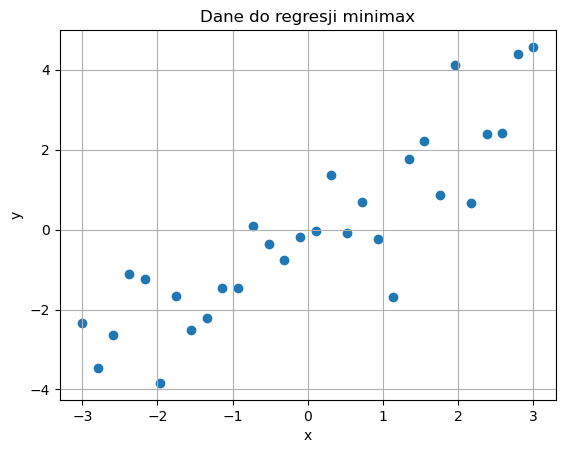

In [46]:
import matplotlib.pyplot as plt

plt.scatter(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Dane do regresji minimax")
plt.grid(True)
plt.show()

Rozmiar problemu prymalnego: (60, 65)
Rozpoczynam obliczenia...
Status: optimal

--- WYNIKI ZADANIA 5 (PRYMALNE) ---
Czas obliczeń: 0.048005 s
a = 1.2066
b = -0.6519
Epsilon = 2.4086


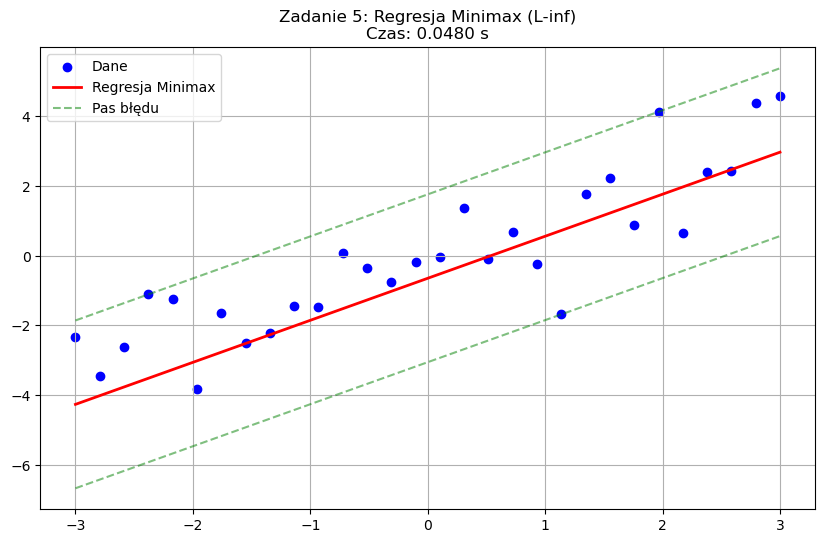

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Zwiększenie tolerancji dla poprawy stabilności numerycznej przy dużej liczbie ograniczeń
global tol
tol = 1e-5

# --- Przygotowanie danych ---
np.random.seed(0)
x_raw = np.linspace(-3, 3, 30)
y_raw = 1.2 * x_raw - 0.5 + np.random.normal(scale=1, size=len(x_raw))

# Dodanie minimalnej perturbacji w celu uniknięcia degeneracji wierzchołków
x_data = x_raw + np.random.normal(0, 1e-8, len(x_raw))
y_data = y_raw + np.random.normal(0, 1e-8, len(y_raw))

n = len(x_data)

# --- Konstrukcja macierzy do zadania prymalnego ---
# Zmienne: a+, a-, b+, b-, epsilon
num_main_vars = 5 
total_vars = num_main_vars + 2 * n

rows = []
d_list = []

for i in range(n):
    xi = x_data[i]
    yi = y_data[i]
    slack_idx_1 = num_main_vars + 2*i
    slack_idx_2 = num_main_vars + 2*i + 1
    
    # Ograniczenie 1: a*xi + b - epsilon <= yi
    row1 = np.zeros(total_vars)
    row1[0] = xi; row1[1] = -xi; row1[2] = 1.0; row1[3] = -1.0; row1[4] = -1.0
    row1[slack_idx_1] = 1.0 
    rows.append(row1)
    d_list.append(yi)
    
    # Ograniczenie 2: -a*xi - b - epsilon <= -yi
    row2 = np.zeros(total_vars)
    row2[0] = -xi; row2[1] = xi; row2[2] = -1.0; row2[3] = 1.0; row2[4] = -1.0
    row2[slack_idx_2] = 1.0 
    rows.append(row2)
    d_list.append(-yi)

C_reg = np.array(rows)
d_reg = np.array(d_list)

# Funkcja celu: min epsilon (współczynnik 1 przy zmiennej epsilon)
b_reg = np.zeros(total_vars)
b_reg[4] = 1.0 

# --- Rozwiązanie z pomiarem czasu ---
print(f"Rozmiar problemu prymalnego: {C_reg.shape}")
print("Rozpoczynam obliczenia...")

start_time = time.time()

try:
    # Wywołanie algorytmu (B0=None wymusza Fazę 1)
    result = revised_simplex(C_reg, d_reg, b_reg, B0=None)
    
    end_time = time.time()
    duration = end_time - start_time

    print("Status:", result["status"])

    if result["status"] == "optimal":
        res_x = result["x"]
        
        # Rekonstrukcja zmiennych decyzyjnych
        a_final = res_x[0] - res_x[1]
        b_final = res_x[2] - res_x[3]
        epsilon = res_x[4]
        
        print(f"\n--- WYNIKI ZADANIA 5 (PRYMALNE) ---")
        print(f"Czas obliczeń: {duration:.6f} s")
        print(f"a = {a_final:.4f}")
        print(f"b = {b_final:.4f}")
        print(f"Epsilon = {epsilon:.4f}")
        
        # Wizualizacja wyników
        plt.figure(figsize=(10, 6))
        plt.scatter(x_raw, y_raw, color='blue', label='Dane')
        y_pred = a_final * x_raw + b_final
        plt.plot(x_raw, y_pred, color='red', linewidth=2, label='Regresja Minimax')
        plt.plot(x_raw, y_pred + epsilon, color='green', linestyle='--', alpha=0.5, label='Pas błędu')
        plt.plot(x_raw, y_pred - epsilon, color='green', linestyle='--', alpha=0.5)
        plt.legend()
        plt.title(f"Zadanie 5: Regresja Minimax (L-inf)\nCzas: {duration:.4f} s")
        plt.grid(True)
        plt.show()
    else:
        print("Nie znaleziono rozwiązania optymalnego.")

except Exception as e:
    print(f"Błąd obliczeń: {e}")

## Zadanie 6 -- dodatkowe; 5 pkt
Zapisz zadanie dualne do zadania optymalizacji z zadania 5. Użyj algorymu simplex do rozwiązania zadania dualnego. Odczytaj wynik zadania prymalnego z wyniku zadania dualnego. Która wersja wykonywała się szybciej?

In [48]:
import numpy as np
import time

# --- 1. Przygotowanie danych ---

n = len(x_data)

# --- 2. Konstrukcja Zadania Dualnego ---
# Wymiar problemu: 3 wiersze (zmienne a, b, eps w prymalnym), 2n kolumn (ograniczenia w prymalnym)

# Macierz C_dual
row_a = np.concatenate((x_data, -x_data))          # Odpowiada zmiennej 'a'
row_b = np.concatenate((np.ones(n), -np.ones(n)))  # Odpowiada zmiennej 'b'
row_eps = np.ones(2 * n)                           # Odpowiada zmiennej 'epsilon'

C_dual = np.vstack((row_a, row_b, row_eps))

# Prawa strona d_dual (koszty zmiennych prymalnych: a i b są wolne/darmowe -> 0, epsilon kosztuje -> 1)
d_dual = np.array([0, 0, 1])

# Funkcja celu b_dual (prawe strony ograniczeń prymalnych: y_i oraz -y_i)
# Minimalizujemy -Cel, aby obsłużyć MAX w dualu algorytmem simpleks dla MIN
b_dual = np.concatenate((-y_data, y_data))

# --- 3. Rozwiązanie z pomiarem czasu ---
print(f"Wymiar macierzy dualnej: {C_dual.shape} (tylko 3 wiersze!)")

start_time_dual = time.time()

# Rozwiązujemy (B0=None -> Faza 1 znajdzie bazę startową dla układu 3 równań)
result_dual = revised_simplex(C_dual, d_dual, b_dual, B0=None)

end_time_dual = time.time()
duration_dual = end_time_dual - start_time_dual

print("Status:", result_dual["status"])

if result_dual["status"] == "optimal":
    # --- 4. Odczytanie wyniku prymalnego (a, b) z rozwiązania dualnego ---
    # Epsilon to wartość funkcji celu (z dokładnością do znaku)
    # a i b to mnożniki Lagrange'a ograniczeń równościowych duala
    
    val_dual = result_dual["obj"]
    epsilon_dual = -val_dual  # Znak minus, bo odwracaliśmy funkcję celu
    
    # Obliczamy zmienne prymalne (a, b) rozwiąjując układ równań dla optymalnej bazy
    B_opt = result_dual["B"]
    C_B = C_dual[:, B_opt]
    b_B = b_dual[B_opt]
    
    # Rozwiązujemy C_B.T * x = b_B
    primal_vars = np.linalg.solve(C_B.T, b_B)
    a_rec = primal_vars[0] *-1
    b_rec = primal_vars[1] *-1
    
    print(f"\n--- WYNIKI ZADANIA 6 (DUALNE) ---")
    print(f"Czas obliczeń: {duration_dual:.6f} s")
    print(f"a = {a_rec:.4f}")
    print(f"b = {b_rec:.4f}")
    print(f"Epsilon = {epsilon_dual:.4f}")
    
    # --- 5. Porównanie czasów ---
    # Sprawdzamy czy zmienna 'duration' z Zadania 5 istnieje
    if 'duration' in globals():
        speedup = duration / duration_dual
        print(f"\n--- PORÓWNANIE ---")
        print(f"Czas prymalny: {duration:.6f} s")
        print(f"Czas dualny:   {duration_dual:.6f} s")
        print(f"PRZYSPIESZENIE: {speedup:.1f} razy szybciej!")
    else:
        print("\nUruchom najpierw komórkę z Zadaniem 5, aby zobaczyć porównanie czasów.")
        
else:
    print("Nie udało się rozwiązać zadania dualnego.")

Wymiar macierzy dualnej: (3, 60) (tylko 3 wiersze!)
Status: optimal

--- WYNIKI ZADANIA 6 (DUALNE) ---
Czas obliczeń: 0.004920 s
a = 1.2066
b = -0.6519
Epsilon = 2.4086

--- PORÓWNANIE ---
Czas prymalny: 0.048005 s
Czas dualny:   0.004920 s
PRZYSPIESZENIE: 9.8 razy szybciej!
